In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import collections
from tensorflow.keras import layers, modelsd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import RMSprop

# Data Exploration

### Laod Dataset

In [3]:
dataset_dir = 'dataset'
dataset = image_dataset_from_directory(dataset_dir, image_size=(128, 128), batch_size=32)

Found 10028 files belonging to 2 classes.


### Visualize sample images

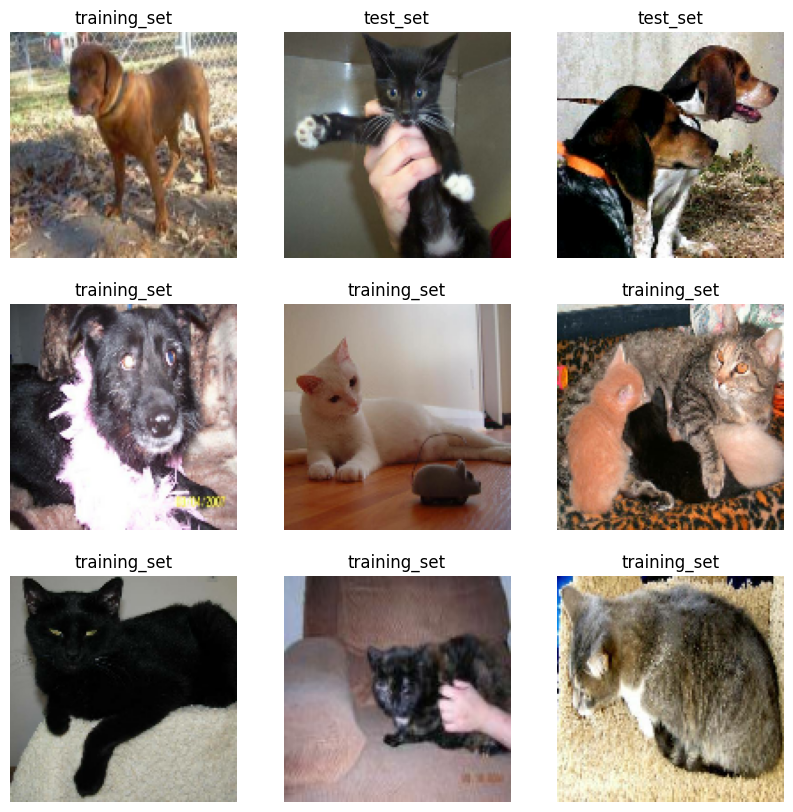

In [4]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### Calculate class distribution

In [5]:
class_distribution = collections.Counter(labels.numpy())
print(f"Class Distribution: {class_distribution}")

Class Distribution: Counter({1: 26, 0: 6})


In [6]:
# it is imbalanced dataset, where there are 29 instances of one class and only 3 of the other 
# we can use various techniques such as:
# Oversampling the minority class: Replicate instances of the minority class to achieve a balanced dataset.
# Undersampling the majority class: Randomly remove instances from the majority class to achieve balance.
# Data Augmentation: Apply transformations to create new instances of the minority class.
# Synthetic Data Generation: Use methods like SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples of the minority class.

#### Data Augmentation

In [7]:
# Sample dummy data creation (You should replace this with your actual data)
# Example: Assume you have 3 class 0 images and 29 class 1 images.
images = np.random.rand(32, 128, 128, 3)  # Replace with your actual images
labels = np.array([0]*3 + [1]*29)          # Replace with your actual labels

# Separate the classes based on labels
class_0 = images[labels == 0]  # Images of class 0 (e.g., cats)
class_1 = images[labels == 1]  # Images of class 1 (e.g., dogs)

# Check class distribution
class_distribution = collections.Counter(labels)
print(f"Original Class Distribution: {class_distribution}")


Original Class Distribution: Counter({1: 29, 0: 3})


In [8]:
# Create an ImageDataGenerator for the minority class (class 0)
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images from class 0
num_to_add = len(class_1) - len(class_0)
augmented_class_0 = data_gen.flow(class_0, 
                                    np.zeros(len(class_0)),  # Dummy labels
                                    batch_size=1)

# Prepare to collect augmented images
augmented_images = []
augmented_labels = []

# Generate enough augmented images to balance the dataset
for _ in range(num_to_add):
    img, lbl = next(augmented_class_0)  # Get one augmented image
    augmented_images.append(img[0])      # img[0] gets the actual image
    augmented_labels.append(0)            # Append the class label (0 for class_0)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine the augmented images with the original classes
balanced_images = np.concatenate([class_0, class_1, augmented_images])
balanced_labels = np.concatenate([np.zeros(len(class_0)), np.ones(len(class_1)), augmented_labels])

# Check the new class distribution
new_distribution = collections.Counter(balanced_labels)
print(f"New Class Distribution: {new_distribution}")


New Class Distribution: Counter({0.0: 29, 1.0: 29})


## Preprocessing

### Resizing, Normalization, Data Augmentation

In [9]:
# Resizing:
# Since the images might come in different sizes, resizing them to a uniform dimension (e.g., 128x128 pixels) ensures consistency in the 
# input shape for the neural network.
# Normalization:
# Image pixel values typically range from 0 to 255. Normalizing these values to the range [0, 1] helps the model converge faster during training by 
# preventing large gradient updates.
# Data Augmentation:
# To prevent overfitting and improve generalization, I'll apply data augmentation techniques such as random rotations, flips, and zooms.

In [10]:
# Define data augmentation sequentially
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

def preprocess_and_augment(image, label):
    # Resize the image
    image = tf.image.resize(image, [128, 128])
    # Normalize the pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Apply data augmentation
    image = data_augmentation(image)
    return image, label

# Update the dataset mapping to include augmentation
dataset = dataset.map(preprocess_and_augment)


# Model Building

In [11]:
# Convolutional Neural Networks (CNNs):
# CNNs automatically learn spatial hierarchies and local patterns in images, making them highly effective for tasks like object detection and 
# classification, particularly when dealing with unstructured data like images.

In [12]:
# Define the CNN model
model = models.Sequential([
   layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
   layers.MaxPooling2D((2, 2)),
   
   layers.Conv2D(64, (3, 3), activation='relu'),
   layers.MaxPooling2D((2, 2)),

   layers.Conv2D(128, (3, 3), activation='relu'),
   layers.MaxPooling2D((2, 2)),

   layers.Flatten(),
   layers.Dense(128, activation='relu'),
   layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.summary()


F:\Cat or Dog ML Project\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training

### Dataset Spliting

In [13]:
# Split the dataset into training (80%) and testing (20%) sets using the following code
train_size = int(0.8 * len(dataset))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

### Compile the Model

In [14]:
# Use binary cross-entropy as the loss function since this is a binary classification problem. 
# The Adam optimizer will be employed for efficient gradient descent.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model training

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 177s 685ms/step - accuracy: 0.7783 - loss: 0.5356 - val_accuracy: 0.8076 - val_loss: 0.4975
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 144s 573ms/step - accuracy: 0.7934 - loss: 0.5125 - val_accuracy: 0.8066 - val_loss: 0.4913
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 622ms/step - accuracy: 0.7925 - loss: 0.5145 - val_accuracy: 0.8076 - val_loss: 0.4932
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 566ms/step - accuracy: 0.7918 - loss: 0.5128 - val_accuracy: 0.8056 - val_loss: 0.4931
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 568ms/step - accuracy: 0.7922 - loss: 0.5128 - val_accuracy: 0.8096 - val_loss: 0.4934
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 567ms/step - accuracy: 0.7928 - loss: 0.5151 - val_accuracy: 0.8071 - val_loss: 0.4912
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 584ms/step - accuracy: 0.7925 - loss: 0.5134 - val_accuracy: 0.8061 - val_loss: 0.4918
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 570ms/step - accuracy: 0.7935 -

# Model Evaluation

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.7926 - loss: 0.5141
Test Accuracy: 0.804108202457428, Test Loss: 0.496232271194458


In [17]:
# Get true labels and images from test_dataset
y_true = []
for img, label in test_dataset:
    y_true.extend(label.numpy())  # Collect true labels

# Get predictions from the model
y_pred = model.predict(test_dataset)
y_pred = np.round(y_pred).flatten()  # Sigmoid outputs between 0 and 1, round them to 0 or 1

# Generate classification report
print(classification_report(y_true, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       397
           1       0.80      1.00      0.89      1599

    accuracy                           0.80      1996
   macro avg       0.40      0.50      0.44      1996
weighted avg       0.64      0.80      0.71      1996



F:\Cat or Dog ML Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
F:\Cat or Dog ML Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
F:\Cat or Dog ML Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Potential Issues and Improvements:
# Overfitting: If the model performs poorly, it might be too complex for the dataset. Solutions include applying more regularization techniques or 
# data augmentation.
# Underfitting: If the model is too simple, increase the number of layers or units in the network.

# Hyperparameter Tuning

In [19]:
# Using RMSprop instead of Adam
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

# Make predictions on the test dataset
y_pred = model.predict(test_dataset)
y_pred = np.round(y_pred).flatten()  # Sigmoid outputs between 0 and 1, round them to 0 or 1

# Extract true labels from the test dataset
y_true = []
for _, label in test_dataset:
    y_true.extend(label.numpy())  # Collect true labels

# Generate a classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 545ms/step - accuracy: 0.8032 - loss: 0.4980 - val_accuracy: 0.7811 - val_loss: 0.5265
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 587ms/step - accuracy: 0.8031 - loss: 0.4987 - val_accuracy: 0.7891 - val_loss: 0.5162
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 594ms/step - accuracy: 0.8017 - loss: 0.5007 - val_accuracy: 0.7856 - val_loss: 0.5202
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 600ms/step - accuracy: 0.8027 - loss: 0.4983 - val_accuracy: 0.7881 - val_loss: 0.5185
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 610ms/step - accuracy: 0.8036 - loss: 0.4966 - val_accuracy: 0.7851 - val_loss: 0.5211
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 171s 681ms/step - accuracy: 0.8011 - loss: 0.5009 - val_accuracy: 0.7806 - val_loss: 0.5268
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 151s 600ms/step - accuracy: 0.8043 - loss: 0.4973 - val_accuracy: 0.7871 - val_loss: 0.5173
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 604ms/step - accuracy: 0.8025 -

F:\Cat or Dog ML Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
F:\Cat or Dog ML Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
F:\Cat or Dog ML Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


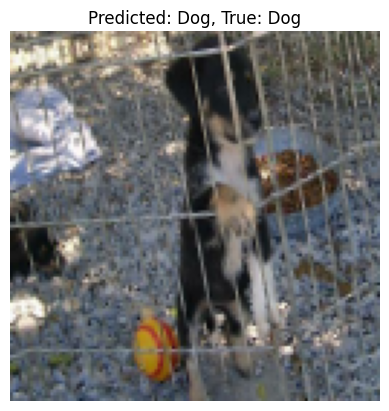

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

# Function to preprocess a single image (resize and normalize)
def preprocess_image(image):
    image = tf.image.resize(image, (128, 128))  # Resize to 128x128
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Pick a random sample from the test dataset
def get_random_sample(test_dataset):
    # Convert test_dataset to a list of batches (for easier sampling)
    dataset_list = list(test_dataset)
    # Pick a random batch and sample
    random_batch = random.choice(dataset_list)
    random_index = random.randint(0, len(random_batch[0]) - 1)
    image, true_label = random_batch[0][random_index], random_batch[1][random_index]
    return image, true_label

# Get a random image and its label from the test dataset
image, true_label = get_random_sample(test_dataset)

# Preprocess the image for prediction
preprocessed_image = preprocess_image(image)

# Expand dimensions to add the batch size (since the model expects a batch of inputs)
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

# Predict the class (0 or 1) using the trained model
prediction = model.predict(preprocessed_image)
predicted_label = np.round(prediction).flatten()[0]  # Convert prediction to binary class (0 or 1)

# Map label to class name (assuming 0 = 'Cat' and 1 = 'Dog')
class_names = ['Cat', 'Dog']
predicted_class = class_names[int(predicted_label)]
true_class = class_names[int(true_label)]

# Plot the image and display its predicted label
plt.imshow(image)  # Original unprocessed image
plt.title(f"Predicted: {predicted_class}, True: {true_class}")
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()